# ASR Streaming Benchmark
---
Benchmark streaming ASR backends (Whisper, Parakeet, Vosk, FastConformer) with configurable parameters.

**Metrics:** WER (Word Error Rate), Latency (ms), RTF (Real-Time Factor)  
**Workflow:** Setup → Configure → Generate Audio → Benchmark → Analyze → Export

**Features:**
- Interactive backend configuration with custom variants
- Real-time audio generation with Ollama + gTTS
- Comprehensive latency analysis (avg, P95, max)
- WER calculation for accuracy comparison
- Automatic export of raw results and summary JSON


# 1. Bootstrap & Setup

Install packages and import libraries.

In [1]:
# Install required packages (China mirrors for faster downloads)
%pip install -q jiwer nest_asyncio soundfile librosa matplotlib seaborn pandas websockets panel -i https://pypi.tuna.tsinghua.edu.cn/simple

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import asyncio
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import seaborn as sns
from jiwer import wer

warnings.filterwarnings('ignore')

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 2. Configuration

Configure ASR backends, parameters, and test settings. Add model variants with different configurations.

In [ ]:
import sys
from pathlib import Path

# Force complete module reload
for module in list(sys.modules.keys()):
    if 'config_ui' in module:
        del sys.modules[module]

# Add helpers directory to path
helpers_dir = Path().absolute() / "helpers"
if str(helpers_dir) not in sys.path:
    sys.path.insert(0, str(helpers_dir))

from config_ui import create_configuration_ui

# ASR Service Endpoints (Docker services)
BACKEND_URLS = {
    'vosk': 'http://vosk-asr:8000',
    'parakeet': 'http://parakeet-asr:8000',
    'whisper': 'http://whisper-asr:8000',
    'fastconformer': 'http://fastconformer-asr:8000'
}

# Backend-specific configuration options
BACKEND_OPTIONS = {
    'whisper': {'VAD_FILTER': True, 'VAD_THRESHOLD': 0.5, 'BEAM_SIZE': 5, 'LANGUAGE': 'en'},
    'parakeet': {'DECODING_STRATEGY': 'greedy', 'BEAM_SIZE': 1, 'LANGUAGE': 'en'},
    'vosk': {'SAMPLE_RATE': 16000, 'LANGUAGE': 'en-us'},
    'fastconformer': {'ATT_CONTEXT_SIZE': 8, 'DECODER_TYPE': 'rnnt', 'BEAM_SIZE': 1, 'BATCH_SIZE': 1}
}

# State variables - FRESH START
variants = []
test_config = {
    "chunk_duration": 1.0, 
    "sample_rate": 16000
}

# Create UI
ui, helpers = create_configuration_ui(variants, test_config, BACKEND_URLS, BACKEND_OPTIONS)

# Extract helper functions
get_backends = helpers['get_backends']
get_config_raw = helpers['get_config']
show_variants = helpers['show_variants']
clear_all = helpers['clear_all']


def get_config():
    """Get configuration with calculated chunk_size."""
    config = get_config_raw()
    config['chunk_size'] = int(config['chunk_duration'] * config['sample_rate'])
    return config


print("✅ Configuration UI Ready!")
print("💡 Functions: get_backends(), get_config(), show_variants(), clear_all()")
print()

# Display the UI
display(ui)

✅ Configuration UI Ready!
💡 Functions: get_backends(), get_config(), show_variants(), clear_all()



# 3. Generate Test Audio

In [88]:
import sys
from pathlib import Path
from IPython.display import display, Audio, HTML
import ipywidgets as widgets

# Add helpers directory to path
helpers_dir = Path().absolute() / "helpers"
if str(helpers_dir) not in sys.path:
    sys.path.insert(0, str(helpers_dir))

from audio_generation import generate_text_with_ollama, text_to_speech_gtts

# Generate audio first
print("🎙️ Generating test audio...")
word_count = test_config.get('word_count', 500)
speech_speed = test_config.get('speech_speed', 1.5)
sample_rate = test_config.get('sample_rate', 16000)

print(f"⚙️ Settings: {word_count} words, {speech_speed}x speed, {sample_rate}Hz")

# Generate text
text = generate_text_with_ollama(word_count=word_count)

# Convert to speech
audio_data = text_to_speech_gtts(text, sample_rate=sample_rate, speed=speech_speed)

print(f"✅ Audio generated! Duration: {len(audio_data)/sample_rate:.2f}s")

# Store for benchmarks
test_audio = (audio_data, text)

def get_test_audio():
    """Get the current audio data and transcript."""
    return test_audio

# Audio player
print(f"🔊 Audio Playback")
display(Audio(data=audio_data, rate=sample_rate, autoplay=False))

# Transcript preview
print(f"📄 Reference Transcript")
print(f"\n{text}")
print(f"\n📌 Use get_test_audio() to access audio and transcript for benchmarks")


🎙️ Generating test audio...
⚙️ Settings: 500 words, 1.5x speed, 16000Hz
✓ Generated text from Ollama model 'qwen3:14b' (491 words)
✓ Generated audio: 2593792 samples (162.11s) at 1.5x speed
✅ Audio generated! Duration: 162.11s
🔊 Audio Playback


📄 Reference Transcript

Ever notice how often AI comes up in conversations these days? It’s like the topic of the moment—whether you’re scrolling through social media, watching the news, or just chatting with friends. And honestly, it’s no wonder. Artificial intelligence isn’t just a buzzword anymore; it’s shaping the way we live, work, and even think. From self-driving cars to apps that predict your next move, AI is everywhere, and it’s only getting more ingrained in our daily lives. But what does that really mean? Let’s unpack it.  

Take healthcare, for example. AI is revolutionizing diagnostics. Imagine a world where a doctor doesn’t have to rely solely on experience to spot a rare disease—instead, an AI system could analyze millions of medical scans in seconds, flagging anomalies the human eye might miss. This isn’t science fiction; it’s already happening. Hospitals are using machine learning to detect cancers earlier, personalize treatments, and even predict patient outcomes base

# 4. Run Benchmarks

Execute streaming benchmarks for all configured variants and save raw results for later analysis.

The raw results (`.pkl`) include all Python objects and can be reloaded to re-run analysis without re-benchmarking.


In [ ]:
from benchmark import run_all_benchmarks

print("✅ Benchmark functions loaded")
print("Starting benchmarks...")

benchmark_results = await run_all_benchmarks(
    get_backends(),
    get_test_audio()[0],  # audio data
    get_config()
)

# Store reference transcript
REFERENCE_TRANSCRIPT = get_test_audio()[1]  # transcript

print(f"\n✅ Benchmarks complete!")
print(f"📊 {len(benchmark_results)} results collected")

✅ Benchmark functions loaded
Starting benchmarks...

🎯 Running benchmarks with:
   • Chunk Duration: 1.0s
   • Sample Rate: 16000Hz
   • Active Variants: ['vosk_0', 'fastconformer_1', 'whisper_2']


Benchmarking: Vosk Default
Backend: VOSK
Configuration: {'SAMPLE_RATE': 16000.0, 'LANGUAGE': 'en-us'}
[Vosk Default] Starting transcription...
[Vosk Default] WebSocket connected to ws://vosk-asr:8000/stream
[Vosk Default] Config sent: {'SAMPLE_RATE': 16000.0, 'LANGUAGE': 'en-us'}
[Vosk Default] Chunk 5/162: 855.11ms - 'how often of these days'
[Vosk Default] Chunk 23/162: 72.72ms - 'Just how often these days he's like the diamonds'
[Vosk Default] Chunk 24/162: 1.69ms - 'yeah'
[Vosk Default] Chunk 25/162: 1.57ms - 'we're watching it is'
[Vosk Default] Chunk 26/162: 1.58ms - 'we're watching these will just be friends'
[Vosk Default] Chunk 27/162: 1.56ms - 'we're watching these will just friends say'
[Vosk Default] Chunk 28/162: 1.48ms - 'we're watching these will just friends say is i wonder'

In [125]:
import pickle
from datetime import datetime
from pathlib import Path

# Export raw benchmark results for reproducibility
timestamp = datetime.now().strftime("%Y%m%d%H%M")
output_dir = Path(".results")
output_dir.mkdir(parents=True, exist_ok=True)

# Save raw results with pickle (includes all Python objects)
raw_results_file = output_dir / f"benchmark_raw_{timestamp}.pkl"
with open(raw_results_file, 'wb') as f:
    pickle.dump({
        'results': benchmark_results,
        'reference_transcript': REFERENCE_TRANSCRIPT,
        'config': get_config(),
        'backends': get_backends(),
        'timestamp': timestamp
    }, f)

print(f"📦 Raw results saved to: {raw_results_file}")

📦 Raw results saved to: .results/benchmark_raw_202512171506.pkl


# 5. Results Analysis

Analyze metrics, visualize latency, calculate WER, and export summary reports.

**Available Analyses:**
- Summary statistics table (avg/P95/max latency)
- WER calculation vs reference transcript  
- Latency distribution charts
- Latency over time progression
- JSON summary export


In [ ]:
# Load previously saved results for analysis
import pickle
from pathlib import Path

# Find the most recent raw results file
results_dir = Path(".results")
raw_files = sorted(results_dir.glob("benchmark_raw_*.pkl"), reverse=True)

if raw_files:
    with open(raw_files[0], 'rb') as f:
        saved_data = pickle.load(f)
    
    benchmark_results = saved_data['results']
    REFERENCE_TRANSCRIPT = saved_data['reference_transcript']
    
    print(f"✅ Loaded results from: {raw_files[0]}")
    print(f"📊 {len(benchmark_results)} benchmark results loaded")
else:
    print("⚠️ No saved results found in .results/ directory")
    print("💡 Run the benchmark cells first to generate results")

In [95]:
from results_analysis import create_results_dataframe, print_results_summary

# Create and display results DataFrame
df_results = create_results_dataframe(benchmark_results)
print_results_summary(df_results)



BENCHMARK RESULTS SUMMARY
              Backend  Avg Latency (ms)  P95 Latency (ms)  Max Latency (ms)                                   Final Transcript
         Vosk Default         79.008238        440.831304        855.113029             Spring, or even three hundred and six.
Fastconformer Default        151.139457        328.534031       2963.318348                                            or even
      Whisper Default        138.360582        130.337346       3053.151608 The bigger question is how we'll choose to use it.


In [ ]:
# Optional: Load previously saved results for analysis
# Uncomment to reload results without re-running benchmarks

# import pickle
# from pathlib import Path
# 
# # Find the most recent raw results file
# results_dir = Path(".results")
# raw_files = sorted(results_dir.glob("benchmark_raw_*.pkl"), reverse=True)
# 
# if raw_files:
#     with open(raw_files[0], 'rb') as f:
#         saved_data = pickle.load(f)
#     
#     benchmark_results = saved_data['results']
#     REFERENCE_TRANSCRIPT = saved_data['reference_transcript']
#     
#     print(f"✅ Loaded results from: {raw_files[0]}")
#     print(f"📊 {len(benchmark_results)} benchmark results loaded")
# else:
#     print("⚠️ No saved results found in .results/ directory")


In [ ]:
from results_analysis import calculate_wer_metrics

successful_results = [r for r in benchmark_results if r.get('success', False)]

# Calculate WER for each backend
calculate_wer_metrics(successful_results, REFERENCE_TRANSCRIPT)



Word Error Rate (WER) Analysis:

VOSK DEFAULT:
  Reference:  'ever notice how often ai comes up in conversations these days? it’s like the topic of the moment—whe...'
  Hypothesis: 'spring, or even three hundred and six....'
  WER: 99.39%

FASTCONFORMER DEFAULT:
  Reference:  'ever notice how often ai comes up in conversations these days? it’s like the topic of the moment—whe...'
  Hypothesis: 'or even...'
  WER: 99.59%

WHISPER DEFAULT:
  Reference:  'ever notice how often ai comes up in conversations these days? it’s like the topic of the moment—whe...'
  Hypothesis: 'the bigger question is how we'll choose to use it....'
  WER: 98.17%


In [ ]:
from results_analysis import create_results_dataframe

# Display results table (using df_results created earlier)
if 'df_results' not in locals():
    # Fallback: create from raw results
    df_results = create_results_dataframe(benchmark_results)

df_display = df_results.copy()

# Round for display
for col in ['wer', 'latency_ms', 'rtf']:
    if col in df_display.columns:
        df_display[col] = df_display[col].round(3)

print("=" * 80)
print("BENCHMARK RESULTS")
print("=" * 80)
display(df_display)

# Highlight best performers
if 'wer' in df_display.columns and not df_display['wer'].isna().all():
    best_wer_idx = df_display['wer'].idxmin()
    best_wer = df_display.loc[best_wer_idx]
    print(f"\n🏆 Best WER: {best_wer['backend']} ({best_wer.get('config', 'N/A')}) - {best_wer['wer']:.3f}")

if 'latency_ms' in df_display.columns and not df_display['latency_ms'].isna().all():
    best_latency_idx = df_display['latency_ms'].idxmin()
    best_latency = df_display.loc[best_latency_idx]
    print(f"⚡ Fastest Latency: {best_latency['backend']} ({best_latency.get('config', 'N/A')}) - {best_latency['latency_ms']:.1f}ms")

if 'rtf' in df_display.columns and not df_display['rtf'].isna().all():
    best_rtf_idx = df_display['rtf'].idxmin()
    best_rtf = df_display.loc[best_rtf_idx]
    print(f"🚀 Best RTF: {best_rtf['backend']} ({best_rtf.get('config', 'N/A')}) - {best_rtf['rtf']:.3f}")

BENCHMARK RESULTS


Backend  Avg Latency (ms)  P95 Latency (ms)  \
0           Vosk Default         79.008238        440.831304   
1  Fastconformer Default        151.139457        328.534031   
2        Whisper Default        138.360582        130.337346   

   Max Latency (ms)                                   Final Transcript  
0        855.113029             Spring, or even three hundred and six.  
1       2963.318348                                            or even  
2       3053.151608  The bigger question is how we'll choose to use...

## Visualization

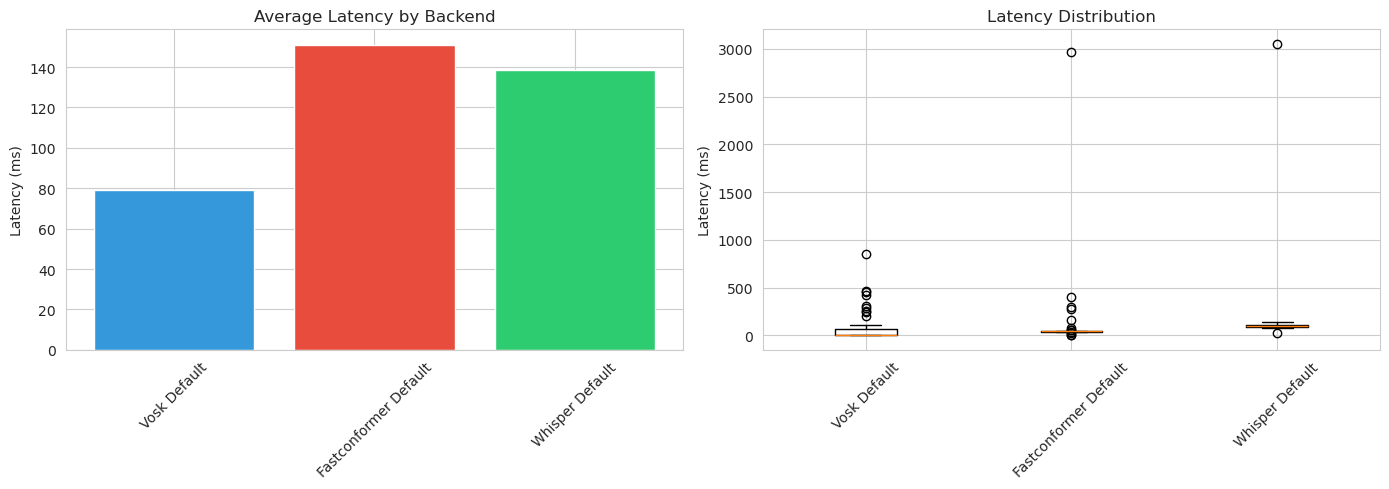

In [96]:
from results_analysis import plot_latency_comparison

# Plot latency comparison
successful_results = [r for r in benchmark_results if r.get('success', False)]
plot_latency_comparison(successful_results)


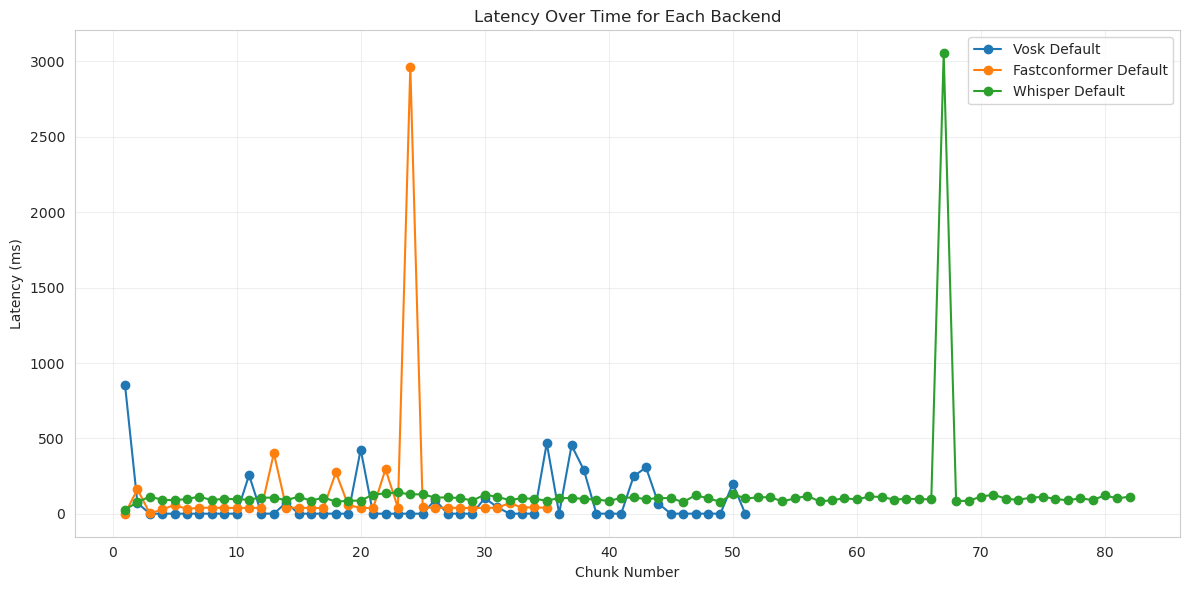

In [97]:
from results_analysis import plot_latency_over_time

# Plot latency over time
plot_latency_over_time(successful_results)


## Export Results

In [ ]:
from datetime import datetime
from pathlib import Path

from results_analysis import export_results_json

# Export summary JSON (this was saved during benchmarks, create new one if needed)
timestamp = datetime.now().strftime("%Y%m%d%H%M")
output_dir = Path(".results")
output_dir.mkdir(parents=True, exist_ok=True)

# Export results summary to JSON
output_file = export_results_json(
    benchmark_results,
    test_audio,
    get_config(),
    output_file=str(output_dir / f"benchmark_summary_{timestamp}.json")
)

print(f"✅ Summary exported to: {output_file}")
print("💡 Raw results were saved during benchmark execution")

✅ Summary exported to: .results/benchmark_summary_202512171500.json
💡 Raw results were saved during benchmark execution
